## 버스 운행시간 데이터를 활용한 데이터 분석
- 버스가 다음 정류장에 도착하기 위해서 걸릴 시간을 예측

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 라이브러리 및 데이터
## Library & Data

In [37]:
import folium#지도 확인

import numpy as np # 행렬 연산 / 데이터 핸들링
import pandas as pd # 데이터 분석
import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
from xgboost import XGBRegressor # XGBoost Regressor 모델
from sklearn.model_selection import KFold # K-validation
from sklearn.metrics import accuracy_score # 정확도 측정 함수
from sklearn.preprocessing import LabelEncoder # 라벨 인코더

In [38]:
# 데이터 불러오기
train_data = pd.read_csv('/content/drive/MyDrive/버스 예측/229611_버스시간예측_data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/버스 예측/229611_버스시간예측_data/test.csv')

## 2. 탐색적 자료분석
## Exploratory Data Analysis (EDA)


In [39]:
train_data.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


+ id : 고유 id
+ date : 버스 운행 날짜
+ route_id : 버스 노선 ID
+ vh_id : 버스 id
+ route_nm : 버스 노선 실제 번호
+ now_latitude : 현재 정류소의 위도
+ now_longitude : 현재 정류소의 경도
+ now_station : 현재 정류소 이름
+ now_arrive_time : 현재 정류장에 도착한 시간
+ distance : 현재 정류장에서 다음 정류장까지 실제 이동한 거리
+ next_station : 다음 정류소 이름
+ next_latitude : 다음 정류소의 위도
+ next_longitude : 다음 정류소의 경도
+ next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값



In [40]:
print(train_data.shape)
print(test_data.shape)

#대략 7:3

(210457, 14)
(91774, 13)
(91774, 2)


In [41]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [42]:
train_data.describe()
#평균적으로 다음 정류장까지 도착되는 시간은 85초이다. 1분30초

,id,route_id,vh_id,now_latitude,now_longitude,distance,next_latitude,next_longitude,next_arrive_time
count,210457.000000,2.104570e+05,2.104570e+05,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000
mean,105228.000000,4.052491e+08,7.988694e+06,33.434528,126.603451,490.256100,33.434711,126.603687,85.380824
std,60753.847139,9.132404e+04,6.774077e+03,0.102350,0.123961,520.563932,0.102224,0.123838,85.051170
min,0.000000,4.051360e+08,7.983000e+06,33.244382,126.473300,97.000000,33.244382,126.473300,6.000000
25%,52614.000000,4.051365e+08,7.983093e+06,33.325283,126.523900,291.000000,33.325283,126.524550,44.000000
50%,105228.000000,4.053201e+08,7.983431e+06,33.484667,126.551050,384.000000,33.484860,126.551050,66.000000
75%,157842.000000,4.053201e+08,7.997041e+06,33.500197,126.650322,542.000000,33.500228,126.650322,102.000000
max,210456.000000,4.053281e+08,7.997124e+06,33.556167,126.935188,7461.000000,33.556167,126.935188,2996.000000


In [43]:
len(train_data['now_station'].unique())#348개의 정류장에 대한 정보들이 있다.

348

In [44]:
train_data.head()#버스 노선의 id와 버스 차량의 id가 중복되는 경우를 관측했다.

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [45]:
train_data[['route_id', 'vh_id']].drop_duplicates().groupby('route_id').count()
#노선별 운영되는 고유의 차량, 전체 운영되는 차량이 많을수록 배차 간격이 짧은 것을 예측해볼 수 있다.

,vh_id
route_id,
405136001,10
405136002,5
405136007,1
405136012,3
405136521,6
405136522,15
405320111,3
405320112,5
405320113,1


In [46]:
train_data[['route_id', 'next_arrive_time']].groupby('route_id').mean()
#노선별 평균 다음 정류장까지 도착하는 시간

,next_arrive_time
route_id,
405136001,92.063688
405136002,108.270852
405136007,94.172947
405136012,111.322633
405136521,114.673939
405136522,101.339188
405320111,68.901710
405320112,67.602392
405320113,68.403649


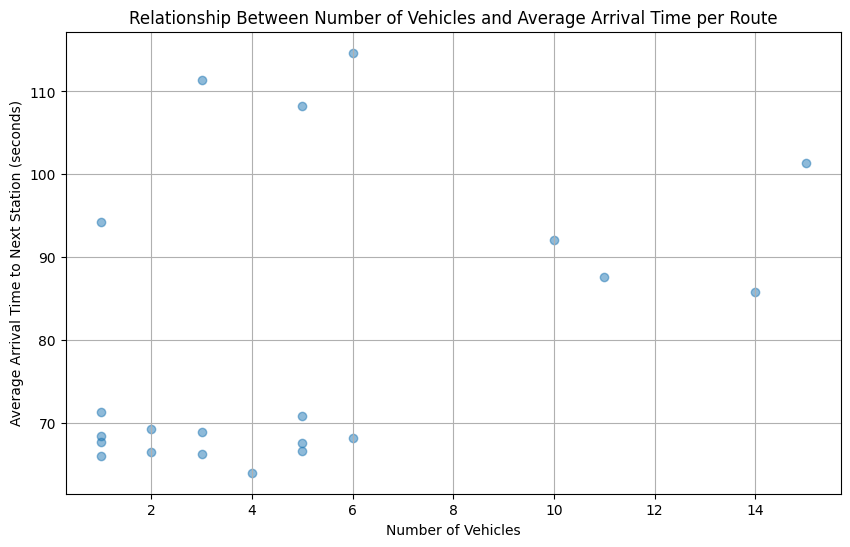

In [47]:
vehicles_per_route = train_data[['route_id', 'vh_id']].drop_duplicates().groupby('route_id').size()


average_arrival_time = train_data[['route_id', 'next_arrive_time']].groupby('route_id').mean()

#위 두 개의 데이터를 머지한다.
merged_data = pd.merge(vehicles_per_route.rename('vehicles_count'), average_arrival_time, on='route_id')

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['vehicles_count'], merged_data['next_arrive_time'], alpha=0.5)
plt.title('Relationship Between Number of Vehicles and Average Arrival Time per Route')
plt.xlabel('Number of Vehicles')
plt.ylabel('Average Arrival Time to Next Station (seconds)')
plt.grid(True)
plt.show()

음.. 노선별 버스의 수와 도착 시간이 무조건적인 비례관계는 아닌 것을 확인했다.

아 그러면 평균도착시간이 긴 친구들은 대체로 노선이 길겠다. 혹은 교통체증이 심한 곳에 위치하겠다.

### folium.Map()
 - location 옵션에 있는 좌표를 중심으로 지도 시각화

In [48]:
coord = [37.4007998, 127.1215168]# 내 동네 좌표
map_osm = folium.Map(location = coord, width='50%', height='50%', zoom_start=15)#해당 좌표를 중심으로 두고 지도를 출력
map_osm

In [49]:
map_data = train_data[['route_id','now_latitude','now_longitude','now_station']]
map_bus_route = map_data[map_data['route_id'] == 405136521].drop_duplicates("now_station")# 위에서 가장 평균도착시간짧았던 노선 405320122
#가장 평균시간이 길었던 노선 405136521

map_osm = folium.Map(location=[33.4134, 126.5190], zoom_start = 10.5)


for item in map_bus_route.index:#해당 노선에 있는 정류장들을 마킹했다.
    lat = map_bus_route.loc[item,'now_latitude']
    long = map_bus_route.loc[item,'now_longitude']

    folium.Marker([lat,long], popup = map_bus_route.loc[item,'now_station'],
                      icon = folium.Icon(color = 'red', icon = 'info-sign')
                      ).add_to(map_osm)

map_osm.save('index.html')

map_osm
#읭?? 짧았던 노선 왜이리 길어 ㅋㅋㅋ

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


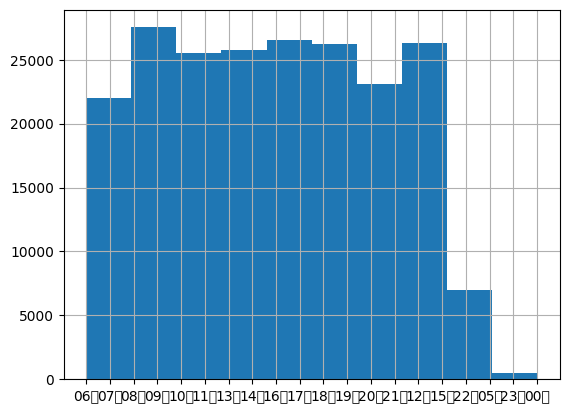

In [50]:
times = train_data['now_arrive_time']
times.hist()

시간대 확인 결과 01시 ~ 04시의 데이터가 존재하지 않는다는 것을 확인하였다.  
'시간대' feature을 만들 때 '새벽'은 추가하지 않는 것으로 결정하였다.

## 3. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [51]:
train_data

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,2019-10-28,405328102,7983486,281-2,33.255783,126.577450,비석거리,21시,528.0,삼아아파트,33.251896,126.574417,96
210453,210453,2019-10-28,405328102,7983486,281-2,33.248595,126.568527,동문로터리,21시,280.0,매일올레시장 7번입구,33.249753,126.565959,50
210454,210454,2019-10-28,405328102,7983486,281-2,33.251891,126.560303,서귀포시 구 버스터미널,21시,114.0,아랑조을거리 입구,33.251084,126.559551,16
210455,210455,2019-10-28,405328102,7983486,281-2,33.251084,126.559551,아랑조을거리 입구,21시,223.0,평생학습관,33.249504,126.558068,38


now_arrive_time을 보면 '시'만 제거하면 도착시간을 쉽게 얻어갈 수 있을 것 같다.

In [52]:
type(train_data['now_arrive_time'][0]) #문자열 타입인 것을 확인

str

In [53]:
train_data['now_arrive_time'] = train_data['now_arrive_time'].str.slice(0,2).astype('int')
test_data['now_arrive_time'] = test_data['now_arrive_time'].str.slice(0,2).astype('int')
#'시'를 제거이후, int타입으로 변환하여 저장

정류장명 인코딩 작업  
XGBoost는 숫자 데이터만 취급하므로 정류장 이름을 LabelEncoder을 이용하여 치환시킨다.

In [54]:
station_encoder = LabelEncoder() # 인코더 생성

_station = list(train_data['now_station'].values) + list(train_data['next_station'].values) # train_data 의 모든 정류장 이름
station_set = set(_station)
print(len(station_set))
station_encoder.fit(list(station_set)) # 인코딩

# 모든 학습, 시험 데이터의 정류장 정보 치환
train_data['now_station'] = station_encoder.transform(train_data['now_station'])
train_data['next_station'] = station_encoder.transform(train_data['next_station'])
test_data['now_station'] = station_encoder.transform(test_data['now_station'])
test_data['next_station'] = station_encoder.transform(test_data['next_station'])
train_data.head()

351


,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,6,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,6,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,6,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,6,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,7,374.0,221,33.485822,126.490897,64


## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

날짜 -> 요일 -> 평일/주말 변환  
먼저 date 값을 이용할 수 있는 의미있는 값으로 변환하기로 하였다.  

datetime을 이용하여 각 날짜를 요일로 변환하고, 이를 바탕으로 평일과 주말 두가지로 분류하기로 하였다.

In [55]:
# 'date' 열을 datetime 유형으로 변환
train_data['date'] = pd.to_datetime(train_data['date'])

# 요일 정보 추출 (0=월요일, ..., 6=일요일)
train_data['weekday'] = train_data['date'].dt.weekday
train_data['weekday'] = train_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)
# 0 ~ 5 는 월요일 ~ 금요일이므로 평일이면 0, 주말이면 1을 설정하였다

train_data = pd.get_dummies(train_data, columns=['weekday']) # 평일/주말에 대해 One-hot Encoding

train_data = train_data.drop('date', axis=1) # 필요없는 date 칼럼을 drop
train_data

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1
0,0,405136001,7997025,360-1,33.456267,126.551750,239,6,266.0,227,33.457724,126.554014,24,True,False
1,1,405136001,7997025,360-1,33.457724,126.554014,227,6,333.0,228,33.458783,126.557353,36,True,False
2,2,405136001,7997025,360-1,33.458783,126.557353,228,6,415.0,235,33.459893,126.561624,40,True,False
3,3,405136001,7997025,360-1,33.479705,126.543811,41,6,578.0,249,33.484860,126.542928,42,True,False
4,4,405136001,7997025,360-1,33.485662,126.494923,63,7,374.0,221,33.485822,126.490897,64,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210452,210452,405328102,7983486,281-2,33.255783,126.577450,95,21,528.0,108,33.251896,126.574417,96,True,False
210453,210453,405328102,7983486,281-2,33.248595,126.568527,65,21,280.0,81,33.249753,126.565959,50,True,False
210454,210454,405328102,7983486,281-2,33.251891,126.560303,122,21,114.0,178,33.251084,126.559551,16,True,False
210455,210455,405328102,7983486,281-2,33.251084,126.559551,178,21,223.0,298,33.249504,126.558068,38,True,False


In [56]:
test_data['date'] = pd.to_datetime(test_data['date'])

# 요일 정보 추출 (0=월요일, ..., 6=일요일)
test_data['weekday'] = test_data['date'].dt.weekday
test_data['weekday'] = test_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)
# 0 ~ 5 는 월요일 ~ 금요일이므로 평일이면 0, 주말이면 1을 설정하였다

test_data = pd.get_dummies(test_data, columns=['weekday']) # 평일/주말에 대해 One-hot Encoding

test_data = test_data.drop('date', axis=1) # 필요없는 date 칼럼을 drop
test_data

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,7,333.0,228,33.458783,126.557353,True,False
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,7,415.0,235,33.459893,126.561624,True,False
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,8,417.0,59,33.478850,126.488350,True,False
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,8,334.0,183,33.480700,126.489933,True,False
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,8,550.0,285,33.482077,126.485355,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91769,302350,405328102,7983486,281-2,33.493625,126.534764,255,20,272.0,10,33.495540,126.532907,True,False
91770,302351,405328102,7983486,281-2,33.495540,126.532907,10,20,447.0,245,33.498925,126.530351,True,False
91771,302352,405328102,7983486,281-2,33.498925,126.530351,245,20,418.0,22,33.500473,126.527103,True,False
91772,302353,405328102,7983486,281-2,33.500473,126.527103,22,20,140.0,287,33.500228,126.525625,True,False


위에서 새벽시간대에서는 버스정보가 없었던 것을 확인했다.

정류장 출발 시간 3분류 변환  
기존 시간을 24개로 두게 되면 모델의 복잡도가 증가할 수 있으므로 과적합을 막기 위해 아침/오후/저녁 3가지 분류로 변환시킨다.  

이후 이를 One-hot Encoding 시킨다.

In [57]:
# time_group 변수를 미리 생성
train_data['time_group'] = 'group'

# 시간대에 따라 time_group 설정
train_data.loc[(train_data['now_arrive_time'] >= 5) & (train_data['now_arrive_time'] < 12), 'time_group'] = 'morning'  # 05~11시
train_data.loc[(train_data['now_arrive_time'] >= 12) & (train_data['now_arrive_time'] < 18), 'time_group'] = 'afternoon'  # 12~17시
train_data.loc[(train_data['now_arrive_time'] >= 18) | (train_data['now_arrive_time'] == 0), 'time_group'] = 'evening'  # 18~00시

# 원-핫 인코딩을 수행
train_data = pd.get_dummies(train_data, columns=['time_group'])

# 불필요한 now_arrive_time 컬럼 제거
train_data = train_data.drop('now_arrive_time', axis=1)

# 결과 확인
train_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,405136001,7997025,360-1,33.456267,126.551750,239,266.0,227,33.457724,126.554014,24,True,False,False,False,True
1,1,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,36,True,False,False,False,True
2,2,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,40,True,False,False,False,True
3,3,405136001,7997025,360-1,33.479705,126.543811,41,578.0,249,33.484860,126.542928,42,True,False,False,False,True
4,4,405136001,7997025,360-1,33.485662,126.494923,63,374.0,221,33.485822,126.490897,64,True,False,False,False,True


In [58]:
test_data['time_group'] = 'group'

# 시간대에 따라 time_group 설정
test_data.loc[(test_data['now_arrive_time'] >= 5) & (test_data['now_arrive_time'] < 12), 'time_group'] = 'morning'  # 05~11시
test_data.loc[(test_data['now_arrive_time'] >= 12) & (test_data['now_arrive_time'] < 18), 'time_group'] = 'afternoon'  # 12~17시
test_data.loc[(test_data['now_arrive_time'] >= 18) | (test_data['now_arrive_time'] == 0), 'time_group'] = 'evening'  # 18~00시

# 원-핫 인코딩을 수행
test_data = pd.get_dummies(test_data, columns=['time_group'])

# 불필요한 now_arrive_time 컬럼 제거
test_data = test_data.drop('now_arrive_time', axis=1)

# 결과 확인
test_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,True,False,False,False,True
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,True,False,False,False,True
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,417.0,59,33.478850,126.488350,True,False,False,False,True
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,334.0,183,33.480700,126.489933,True,False,False,False,True
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,550.0,285,33.482077,126.485355,True,False,False,False,True


필요없는 관측치는 제거한다.  
route_nm은 route_id와 같은 역할 (노선 구별 역할) 그러므로 제거  
latitude, longitude는 모델에게 의미없다고판단

In [59]:
train_data = train_data.drop(['route_nm', 'next_latitude', 'next_longitude',
                              'now_latitude', 'now_longitude'], axis=1)
train_data.head()

,id,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,405136001,7997025,239,266.0,227,24,True,False,False,False,True
1,1,405136001,7997025,227,333.0,228,36,True,False,False,False,True
2,2,405136001,7997025,228,415.0,235,40,True,False,False,False,True
3,3,405136001,7997025,41,578.0,249,42,True,False,False,False,True
4,4,405136001,7997025,63,374.0,221,64,True,False,False,False,True


In [60]:
test_data = test_data.drop(['route_nm', 'next_latitude', 'next_longitude',
                              'now_latitude', 'now_longitude'], axis=1)
test_data.head()

,id,route_id,vh_id,now_station,distance,next_station,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,227,333.0,228,True,False,False,False,True
1,210458,405136001,7997025,228,415.0,235,True,False,False,False,True
2,210459,405136001,7997025,323,417.0,59,True,False,False,False,True
3,210460,405136001,7997025,59,334.0,183,True,False,False,False,True
4,210461,405136001,7997025,183,550.0,285,True,False,False,False,True


**학습 데이터 구성하기**

In [61]:

# 학습 데이터 칼럼에서 목표치인 next_arrive_time만 제거하여 선택한다.
input_var = list(train_data.columns)
input_var.remove('next_arrive_time')

Xtrain = train_data[input_var] # 학습 데이터 선택
Ytrain = train_data['next_arrive_time'] # target 값인 Y 데이터 선택

Xtest = test_data[input_var] # 시험 데이터도 선택

## 5. 모델 학습 및 검증

빠른 학습과 정밀도를 보장하는 eXtreme Gradient Boosting 을 사용한다.

K-Fold를 이용하여 K-Validation을 수행한다.

(random seed는 Regressor 110, KFold 777 고정)

In [62]:
model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)#스레드 23개, 980개의 결정트리
kfold = KFold(n_splits=8, shuffle=True, random_state=777)#7개
n_iter = 0
cv_score = []

def rmse(target, pred):#평균 제곱근 오차
    return np.sqrt(np.sum(np.power(target - pred, 2)) / np.size(pred))

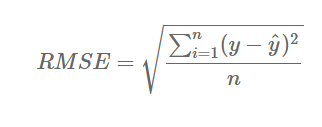

In [63]:
for train_index, test_index in kfold.split(Xtrain, Ytrain):
    # K Fold가 적용된 train, test 데이터를 불러온다
    X_train, X_test = Xtrain.iloc[train_index,:], Xtrain.iloc[test_index, :]
    Y_train, Y_test = Ytrain.iloc[train_index], Ytrain.iloc[test_index]

    # 모델 학습과 예측 수행
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    print(pred)

    # 정확도 RMSE 계산
    n_iter += 1
    score = rmse(Y_test, pred)
    print(score)
    cv_score.append(score)
print('\n교차 검증별 RMSE :', np.round(cv_score, 4))
print('평균 검증 RMSE :', np.mean(cv_score))

[223.86842   66.0268    63.44766  ...  91.27688  147.91179   21.195995]
64.27841317642331
[ 49.056423  68.61231   79.846054 ...  99.91121   32.882984 105.14576 ]
64.74288356930757
[155.607    116.431885 113.43853  ...  58.44948  145.76321   28.484049]
56.90044100246917
[81.99581  71.916016 90.96007  ... 93.469734 70.20131  14.024437]
62.39861170096929
[ 33.70168   82.32525   74.87024  ...  75.005104  84.6898   127.15234 ]
51.275018015180436
[ 29.214853 150.73715  124.94726  ... 239.06522   91.63476  -25.477663]
56.82515368196426
[ 21.30508  117.070854 100.84114  ...  95.49885  109.12133   32.19829 ]
61.36519032374543
[191.92581   27.188892  55.69868  ... 119.846405  72.45942  118.46898 ]
48.623898289448746

교차 검증별 RMSE : [64.2784 64.7429 56.9004 62.3986 51.275  56.8252 61.3652 48.6239]
평균 검증 RMSE : 58.30120121993853


데이터 Feature 중요도 분석

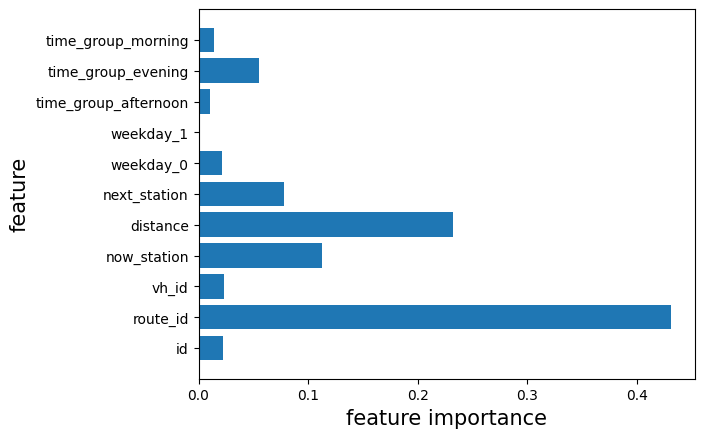

1.0000001

In [64]:
n_feature = X_train.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center') #
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()
np.sum(model.feature_importances_)

버스 노선이 가장 중요하게 작용되었다.

In [65]:
result = model.predict(Xtest) # 시험 데이터 예측

test_data['next_arrive_time'] = result # next_arrive_time 예측 결과로 추가
test_data[['id', 'next_arrive_time']].to_csv('submission.csv',index=False, float_format='%.14f') # csv로 변환

## 6. 결과 및 결언
## Conclusion & Discussion